# Clase 8: autoencoders variacionales (VAE)

**Profesor de Cátedra:** José M. Saavedra.

**Profesor Auxiliar:** Cristóbal Loyola (cloyola@dcc.uchile.cl)

En este tutorial estudiaremos un modelo de autoencoder variacional, tomando como base los repositorios [jmsaavedrar/vae](https://github.com/jmsaavedrar/vae/) y [jmsaavedrar/convnet2](https://github.com/jmsaavedrar/convnet2).

Para esto usaremos el dataset QuickDraw-Animals (el mismo de la tarea), que es un subconjunto del dataset Quick, Draw! de Google (más información [aquí](https://quickdraw.withgoogle.com/data)). El subconjunto que usaremos contiene sketches de animales divididos en 12 clases, con 12.000 imágenes de entrenamiento y 2.399 imágenes de test ([link de descarga](https://www.dropbox.com/sh/hsqjv0kd13xda3g/AABYkVk0ruG85s4aL4C1nDKaa?dl=0)).

Se usará el autoencoder variacional para las siguintes tareas:

* Reconstrucción de las imágenes de test.

* Visualizar el espacio de representaciones.

* Morphing.

La arquitectura de VAE que estudiaremos se puede ver en la siguiente imagen:

<img src='https://drive.google.com/uc?id=1NZn4_1DLFSpOh3mmz5hWOJWkJIRNhX1t'>


In [ ]:
# Clonamos los repositorios
!git clone https://github.com/jmsaavedrar/convnet2.git
!git clone https://github.com/jmsaavedrar/vae.git

!pwd  # muestra el directorio actual
!ls   # muestra el contenido de este (archivos y directorios)

Cloning into 'convnet2'...
remote: Enumerating objects: 279, done.
remote: Counting objects: 100% (279/279), done.
remote: Compressing objects: 100% (188/188), done.
remote: Total 279 (delta 177), reused 161 (delta 84), pack-reused 0
Receiving objects: 100% (279/279), 77.21 KiB | 12.87 MiB/s, done.
Resolving deltas: 100% (177/177), done.
Cloning into 'vae'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 32 (delta 8), reused 17 (delta 3), pack-reused 0
Unpacking objects: 100% (32/32), done.
/content
convnet2  sample_data  vae


## Preparación de los datos

In [ ]:
# Crear directorios para datos y snapshots
!mkdir /content/convnet2/snapshots
!mkdir /content/convnet2/logs
!mkdir /content/convnet2/data

!ls /content/convnet2

configs   models	      ssearch.py	     train_siamese.py
data	  README.md	      ssearch_with_merge.py  train_simple.py
datasets  release_siamese.py  test_tfrecords.py      utils
logs	  snapshots	      train.py


In [ ]:
# Descargar y descomprimir los datos
%cd /content/convnet2/data
!wget https://www.dropbox.com/sh/hsqjv0kd13xda3g/AABYkVk0ruG85s4aL4C1nDKaa -O data.zip
!unzip -q data.zip
!unzip -q train_images.zip
!unzip -q test_images.zip
!rm data.zip
!rm train_images.zip
!rm test_images.zip
!ls

/content/convnet2/data
--2021-11-11 19:25:42--  https://www.dropbox.com/sh/hsqjv0kd13xda3g/AABYkVk0ruG85s4aL4C1nDKaa
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/raw/hsqjv0kd13xda3g/AABYkVk0ruG85s4aL4C1nDKaa [following]
--2021-11-11 19:25:43--  https://www.dropbox.com/sh/raw/hsqjv0kd13xda3g/AABYkVk0ruG85s4aL4C1nDKaa
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc9cc37b008135fa5b043f737f77.dl.dropboxusercontent.com/zip_download_get/A9KbZOMmBDt-6WJIE0ulG6_YbL9PAAi854n_JFBrbgawmworpJgYkr5ZFoP9ToGJNNt_q-zPMwixxvJq9RzlMdPsnYEttfCWeJ8x4vgfaELrLA# [following]
--2021-11-11 19:25:43--  https://uc9cc37b008135fa5b043f737f77.dl.dropboxusercontent.com/zip_download_get/A9KbZOMmBDt-6WJIE0ulG6_YbL9PAAi854n_JFBrbgawmworpJgYkr5ZFoP9To

In [ ]:
mapping_dict = {'sheep': 0, 'bear': 1, 'bee': 2, 'cat': 3, 'camel': 4, 'cow': 5, 
                'crab': 6, 'crocodile': 7, 'duck': 8, 'elephant': 9, 'dog': 10, 'giraffe': 11}

In [ ]:
# Generar archivos de train y test
import os
import pandas as pd

def generate_annotations(base_dir, datasettype='test'):
    filenames = []
    labels = []
    data_prefix = f"data/{datasettype}_images/"
    data_dir = os.path.join(base_dir, data_prefix)
    print(f"buscando en el directorio: {data_dir}")
    # r=root, d=directories, f = files
    for r, d, f in os.walk(data_dir):
        for file in f:
            category_name = r.split('/')[-1]
            file = f"{category_name}/{file}"
            filenames.append(os.path.join(data_prefix, file))
            labels.append(mapping_dict[category_name])
    print(f"total de imágenes: {len(filenames)}")

    df = pd.DataFrame()
    df['filename'] = filenames
    df['cat_id'] = labels
    df = df.sample(frac=1)

    df.to_csv(f"{datasettype}.txt", sep='\t', header=False, index=False)

In [ ]:
%cd /content/convnet2/data
generate_annotations("/content/convnet2/", 'test')
generate_annotations("/content/convnet2/", 'train')

!ls

/content/convnet2/data
buscando en el directorio: /content/convnet2/data/test_images/
total de imágenes: 2399
buscando en el directorio: /content/convnet2/data/train_images/
total de imágenes: 12000
mapping.txt  test_images  test.txt  train_images  train.txt


In [ ]:
# Visualizamos las primeras líneas de test.txt
!cat test.txt | more

data/test_images/bear/023_00133713.jpg	1
data/test_images/dog/091_00151118.jpg	10
data/test_images/cat/064_00122201.jpg	3
data/test_images/camel/054_00120374.jpg	4
data/test_images/cat/064_00122020.jpg	3
data/test_images/crocodile/084_00126773.jpg	7
data/test_images/crocodile/084_00126761.jpg	7
data/test_images/sheep/258_00125081.jpg	0
data/test_images/sheep/258_00124931.jpg	0
data/test_images/crab/082_00125898.jpg	6
data/test_images/crocodile/084_00126740.jpg	7
data/test_images/sheep/258_00124922.jpg	0
data/test_images/crocodile/084_00126775.jpg	7
data/test_images/elephant/103_00125931.jpg	9
data/test_images/crab/082_00125849.jpg	6
data/test_images/crab/082_00125764.jpg	6
data/test_images/dog/091_00151021.jpg	10
data/test_images/elephant/103_00125870.jpg	9
data/test_images/bee/026_00119868.jpg	2
data/test_images/elephant/103_00125809.jpg	9
data/test_images/duck/099_00134298.jpg	8
data/test_images/giraffe/129_00126127.jpg	11
data/test_images/camel/054_00120343.jpg	4
^C


## Generación de TFRecords

En el archivo ```/content/vae/configs/sbir_vae.config``` agregamos las siguientes líneas:

* NUM_EPOCHS = 30
* NUM_CLASSES = 12
* VALIDATION_STEPS = 19
* SNAPSHOT_DIR = /content/convnet2/snapshots/
* DATA_DIR = /content/convnet2/data/
* Comentamos la línea CKPFILE = ...

In [ ]:
# Creamos los tfrecords
%cd /content/convnet2
!python datasets/create_tfrecords.py -type all -config /content/vae/configs/sbir_vae.config -name SBIR
!ls data/

/content/convnet2
---0
---500
---1000
---1500
---2000
---2500
---3000
---3500
---4000
---4500
---5000
---5500
---6000
---6500
---7000
---7500
---8000
---8500
---9000
---9500
---10000
---10500
---11000
---11500
---11999
train_record saved at /content/convnet2/data/train.tfrecords.
mean_file (128, 128, 1)
mean_file saved at /content/convnet2/data/mean.dat.
shape_file saved at /content/convnet2/data/shape.dat.
---0
---500
---1000
---1500
---2000
---2398
test_record saved at /content/convnet2/data/test.tfrecords.
tfrecords created for /content/convnet2/data/
mapping.txt  shape.dat	  test.tfrecords  train_images	   train.txt
mean.dat     test_images  test.txt	  train.tfrecords


## Entrenamiento

Debemos agregar al archivo ```/content/vae/train.py``` la siguiente línea: ```sys.path.append('/content/convnet2/')```.

In [ ]:
# Entrenar el modelo
%cd /content/vae
!python train.py -config ./configs/sbir_vae.config -name SBIR -mode train

/content/vae
[128 128   1]
2021-10-27 02:42:13.285603: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-27 02:42:13.673942: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-27 02:42:13.674822: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-27 02:42:13.676398: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-27 02:42:13.677291: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] succe

In [ ]:
!cp /content/convnet2/snapshots/030.h5 /content/drive/MyDrive/2021-2/sección_1/08/snapshots

In [ ]:
#!cp /content/drive/MyDrive/2021-2/sección_1/08/snapshots/030.h5 /content/convnet2/snapshots/

## Predicciones

Para predecir, en el archivo  ```/content/vae/train.py``` agregamos lo siguiente antes de la línea 125 (filename = ...):

```
output_name = filename.split('/')[-1]
plt.savefig(output_name)            
```

En el mismo archivo, cambiamos la línea 120 por ```xs[0].imshow(np.squeeze(image), cmap = 'gray')```

Finalmente, en el archivo de configuración ```/content/vae/configs/sbir_vae.config``` agregamos el checkpoint obtenido en el entrenamiento con la línea ```CKPFILE = /content/convnet2/snapshots/030.h5```.

In [ ]:
%cd /content/vae
!python train.py -config ./configs/sbir_vae.config -name SBIR -mode predict

/content/vae
[128 128   1]
2021-10-27 03:07:18.717784: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-27 03:07:18.726264: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-27 03:07:18.727091: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-27 03:07:18.728580: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-27 03:07:18.729591: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] succe

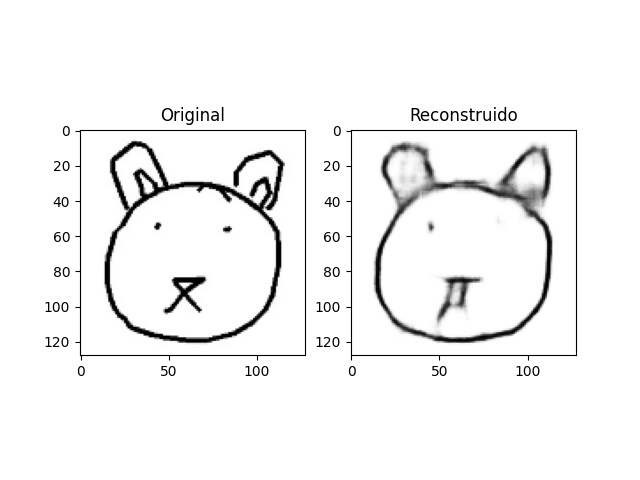

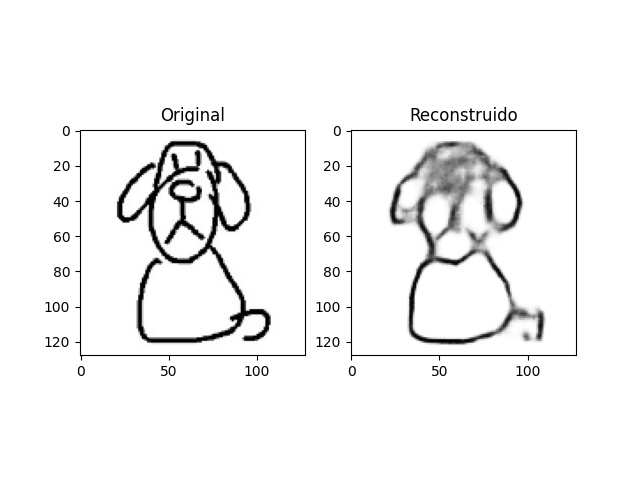

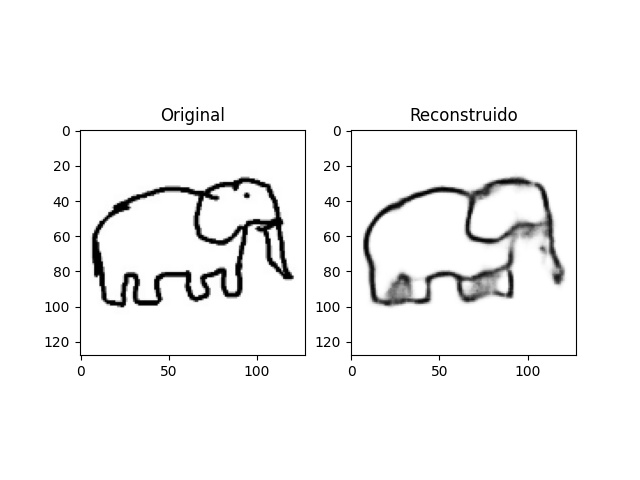

In [ ]:
from IPython.display import Image, display

display(Image("/content/vae/023_00133603.jpg"))
display(Image("/content/vae/091_00150969.jpg"))
display(Image("/content/vae/103_00125791.jpg"))

## Visualización del espacio de representaciones

El vector $\mu$ generado por el encoder puede ser usado como representación de los sketches. Para entender la capacidad de representación de $\mu$, generaremos una visualización de los datos de entrenamiento con el método
t-SNE, usando distintos colores para las distintas clases.

Para esto hacemos las siguientes modificaciones:

* En el archivo ```/content/vae/utils_vae/parsers.py``` agregamos la siguiente función:

```
def get_labels_from_tfr(serialized_input, number_of_classes):
    features = tf.io.parse_example([serialized_input],
                            features={
                                    'image': tf.io.FixedLenFeature([], tf.string),
                                    'label': tf.io.FixedLenFeature([], tf.int64)
                                    })
    label = tf.cast(features['label'], tf.int64)
    label = tf.one_hot(label, depth=number_of_classes)
    label = tf.reshape(label, [number_of_classes])

    return label
```

* En el archivo ```/content/vae/train.py```:

    * En la línea 32, agregamos la opción 'visualize'.

    * Reemplazamos las líneas 37 y 43 por  
    ```if pargs.mode == 'train' or pargs.mode == 'visualize':```

    * Agregamos lo siguiente al final del archivo (con la indentación correcta):

```
# visualize data with T-SNE
elif pargs.mode == 'visualize':
    import pandas as pd
    import seaborn as sns
    from sklearn.manifold import TSNE

    sns.set(rc={"figure.figsize":(10, 10)})

    labels_dict = {0: "sheep", 1: "bear", 2: "bee", 3: "cat", 4: "camel", 5:
                    "cow", 6: "crab", 7: "crocodile", 8: "duck", 9: "elephant", 10:
                    "dog", 11: "giraffe" }

    tr_dataset = tf.data.TFRecordDataset(tfr_train_file)
    tr_dataset_imgs = tr_dataset.map(lambda x : parsers.parser_tfrecord_vae(x, input_shape));
    tr_dataset_imgs = tr_dataset_imgs.batch(batch_size = configuration.get_batch_size())
    tr_dataset_labels = tr_dataset.map(lambda x: parsers.get_labels_from_tfr(x, number_of_classes))

    predictions = model.predict(tr_dataset_imgs)
    labels = list(tr_dataset_labels.as_numpy_iterator())
    labels = np.array(labels)
    labels = np.argmax(labels, axis=-1)

    mu_log_var = predictions[:, :256]
    np.save("mu_log_var", mu_log_var)
    x_pred = predictions[:, 256:]
    x_pred = np.reshape(x_pred, (x_pred.shape[0], 128, 128))

    print(f"predictions.shape = {predictions.shape}")
    print(f"mu_log_var.shape = {mu_log_var.shape}")
    print(f"x_pred.shape = {x_pred.shape}")
    print(f"labels.shape = {np.array(labels).shape}")

    labels_names = [labels_dict[x] for x in labels]
    np.save("labels_names", np.array(labels_names))
    mu_matrix = mu_log_var[:, :128]

    X_embedded = TSNE(n_components=2).fit_transform(mu_matrix)
    x1 = X_embedded[:, 0]
    x2 = X_embedded[:, 1]

    tsne_df = pd.DataFrame()
    tsne_df["x1"] = x1
    tsne_df["x2"] = x2
    tsne_df["labels"] = labels_names
    print(tsne_df.head())

    sns.scatterplot(data=tsne_df, x="x1", y="x2", hue="labels", sizes=(10, 10));
    plt.savefig("tsne.png")
```

In [ ]:
%cd /content/vae
!python train.py -config ./configs/sbir_vae.config -name SBIR -mode visualize

/content/vae
[128 128   1]
2021-10-27 03:16:16.347558: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-27 03:16:16.356122: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-27 03:16:16.357062: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-27 03:16:16.358500: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-27 03:16:16.359391: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] succe

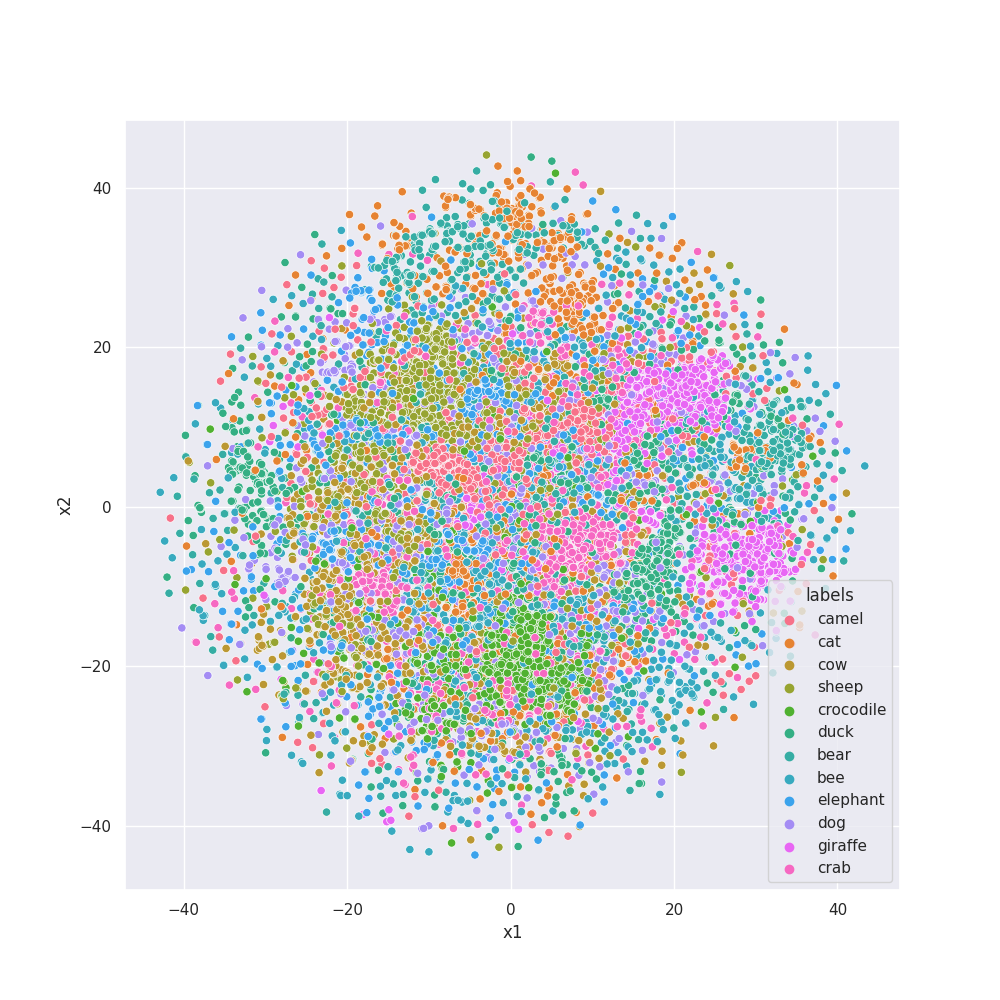

In [ ]:
from IPython.display import Image, display

display(Image("/content/vae/tsne.png"))

In [ ]:
%cd /content/vae
!python train.py -config ./configs/sbir_vae.config -name SBIR -mode visualize

/content/vae
[128 128   1]
2021-11-11 19:52:09.904523: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  1262432   
                                                                 
 decoder (Decoder)           multiple                  658561    
                                                                 
Total params: 1,920,993
Trainable params: 1,920,097
Non-trainable params: 896
_________________________________________________________________
predictions.shape = (12000, 16640)
mu_log_var.shape = (12000, 256)
x_pred.shape = (12000, 128, 128)
labels.shape = (12000,)


In [ ]:
!cp /content/vae/*.npy /content/drive/MyDrive/2021-2/sección_1/08/snapshots

In [ ]:
#!cp /content/drive/MyDrive/2021-2/sección_1/08/snapshots /content/vae

## Morphing

Finalmente, podemos usar las representaciones generadas para hacer *morphing* entre dos imágenes. 

Sea $S_0$ y $S_1$ el sketch inicial y final, respectivamente. Usando el enconder podemos asociar $S_0$ con $\mu_0$ y $S_1$ con $\mu_1$. El objetivo es generar 10 imágenes intermedias con el decoder. Para ello, interpolaremos 10 valores de $\mu$ entre $\mu_0$ y $\mu_1$ bajo la siguiente expresión:

$$\mu_t = \mu_0 (1- t) + \mu_1 t$$

Notemos que cuando t = 0, entonces estamos en $\mu_0$ y cuando t = 1 estamos en $\mu_1$. Cada uno de los $\mu_t$ servirán para generar una imagen intermedia a través del decoder.

In [ ]:
%cd /content/vae

import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tensorflow as tf
sys.path.append('/content/convnet2')
import utils.configuration as conf
from models import vae

def get_model():

    configuration_file = "./configs/sbir_vae.config"
    configuration = conf.ConfigurationFile(configuration_file, "SBIR")
        
    mean_file = os.path.join(configuration.get_data_dir(), "mean.dat")
    shape_file = os.path.join(configuration.get_data_dir(),"shape.dat")
    #
    input_shape =  np.fromfile(shape_file, dtype=np.int32)
    print(input_shape)
    mean_image = np.fromfile(mean_file, dtype=np.float32)
    mean_image = np.reshape(mean_image, input_shape)        
    number_of_classes = configuration.get_number_of_classes()
       
    model = vae.VAE([32,64,64,64])            
            
    input_image = tf.keras.Input((input_shape[0], input_shape[1], input_shape[2]), name = 'input_image')     
    model(input_image)    
    model.summary()
    #use_checkpoints to load weights
    if configuration.use_checkpoint():
        print("Loading weights from {}".format(configuration.get_checkpoint_file()))
        model.load_weights(configuration.get_checkpoint_file(), by_name = True, skip_mismatch = True)
    
    return model


def get_reconstruction_from_index(model, mu_matrix, idx):
    mu = mu_matrix[idx]
    mu = np.expand_dims(mu, 0)
    img = model.decoder(mu).numpy()
    img = np.squeeze(model.decoder(mu).numpy())
    img = np.uint8(255 - img * 255)

    return mu, img


def get_reconstruction_from_mu(model, mu):
    # mu = np.expand_dims(mu, 0)
    img = model.decoder(mu).numpy()
    img = np.squeeze(model.decoder(mu).numpy())
    img = np.uint8(255 - img * 255)

    return img

/content/vae


In [ ]:
# Cargamos la matriz de medias y el modelo
labels_names = np.load("/content/vae/labels_names.npy")  # generado en la sección de t-SNE
mu_log_var = np.load("/content/vae/mu_log_var.npy")      # generado en la sección de t-SNE
mu_matrix = mu_log_var[:, :128]
model = get_model()

[128 128   1]
Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  1262432   
                                                                 
 decoder (Decoder)           multiple                  658561    
                                                                 
Total params: 1,920,993
Trainable params: 1,920,097
Non-trainable params: 896
_________________________________________________________________
Loading weights from /content/convnet2/snapshots/030.h5


bear --> dog


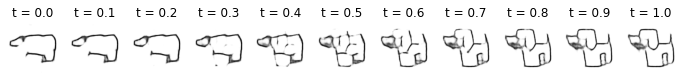

In [ ]:
# Morphing entre dos imágenes aleatorias
idx0, idx1 = np.random.randint(0, len(mu_matrix), size=2)
print(f"{labels_names[idx0]} --> {labels_names[idx1]}")

mu_0, img_0 = get_reconstruction_from_index(model, mu_matrix, idx0)
mu_1, img_1 = get_reconstruction_from_index(model, mu_matrix, idx1)

fig, ax = plt.subplots(1, 11, figsize=(12, 50))

for ix, t in enumerate(np.arange(0, 1.1, 0.1)):
    mu_t = mu_0 * (1 - t) + mu_1 * t
    img_t = get_reconstruction_from_mu(model, mu_t)

    ax[ix].imshow(img_t, cmap="gray")
    ax[ix].axis("off")
    ax[ix].set_title(f"t = {t.round(decimals=1)}")